In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import yaml

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, balanced_accuracy_score
from sklearn.calibration import CalibrationDisplay


from lightgbm import LGBMClassifier


pd.set_option("display.max_columns", 200)
np.random.seed(42)


In [ ]:
# set the model paths
ROOT = Path("..")
CFG_PATH = ROOT / "configs" / "config.yaml"
MODEL_PATH = ROOT / "data" / "processed" / "model_table.csv"

CFG_PATH.exists(), MODEL_PATH.exists()


In [ ]:
# Read the configuration file
cfg = yaml.safe_load(CFG_PATH.read_text())
cfg

In [ ]:
# load the model table in notebook 01
df = pd.read_csv(MODEL_PATH)
df.shape, df.columns.tolist()

# Quick sanity check on key fields
df[["ph", "depth", "longitude", "latitude", "y"]].describe(include="all")


In [ ]:
# check class balance on the dataset
df["y"] = pd.to_numeric(df["y"], errors="coerce").astype(int)
df["y"].value_counts()


In [ ]:
# # num of geology categories
# vc = df["geology_unit"].value_counts()
# df["geology_unit"].nunique(), (vc < 10).sum(), vc.head(15)


In [ ]:
# review coordinate ranges in the dataset
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
lat_min, lat_max = df["latitude"].min(), df["latitude"].max()

(lon_min, lon_max, lat_min, lat_max)


In [ ]:
# create a quantile-based bin for the spatial CV to allow nearby wells to be sampled in the same train and test dataset

n_bins = cfg["spatial_cv"].get("n_bins", 10)

df["lon_bin"] = pd.qcut(df["longitude"], q=n_bins, duplicates="drop")
df["lat_bin"] = pd.qcut(df["latitude"], q=n_bins, duplicates="drop")
df["block_id"] = df["lon_bin"].astype(str) + "|" + df["lat_bin"].astype(str)

df["block_id"].nunique(), df["block_id"].value_counts().head(10)



In [ ]:
# create a baseline logistic regression model 
num_features = ["ph", "depth"]
cat_features = ["geology_unit"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
        ]), num_features),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_features),
    ],
    remainder="drop",
)

baseline_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced")),
])


In [ ]:
# define a function to run group spatial cv and return overall metrics and diagnostics
def eval_spatial_cv(df, pipe, n_splits=5, group_col="block_id", y_col="y"):
    gkf = GroupKFold(n_splits=n_splits)

    y_true_all = []
    y_prob_all = []
    fold_rows = []

    for fold, (tr, te) in enumerate(gkf.split(df, df[y_col], groups=df[group_col]), start=1):
        train = df.iloc[tr].copy()
        test = df.iloc[te].copy()

        y_tr = train[y_col].astype(int)
        y_te = test[y_col].astype(int)

        pipe.fit(train, y_tr)
        p = pipe.predict_proba(test)[:, 1]

        y_true_all.append(y_te.to_numpy())
        y_prob_all.append(p)

        fold_rows.append({
            "fold": fold,
            "n_test": len(test),
            "pos_test": int(y_te.sum()),
            "roc_auc": roc_auc_score(y_te, p) if y_te.nunique() > 1 else np.nan,
            "pr_auc": average_precision_score(y_te, p),
        })

    y_true_all = np.concatenate(y_true_all)
    y_prob_all = np.concatenate(y_prob_all)

    # Quick threshold scan so we don't get stuck on 0.5 for an imbalanced dataset.
    thresholds = np.linspace(0.05, 0.95, 19)
    bal_scores = []
    for t in thresholds:
        pred = (y_prob_all >= t).astype(int)
        bal_scores.append(balanced_accuracy_score(y_true_all, pred))

    best_i = int(np.argmax(bal_scores))

    metrics = {
        "roc_auc": roc_auc_score(y_true_all, y_prob_all),
        "pr_auc": average_precision_score(y_true_all, y_prob_all),
        "best_threshold": float(thresholds[best_i]),
        "balanced_acc_best": float(bal_scores[best_i]),
        "n": int(len(df)),
        "pos": int(df[y_col].sum()),
        "pos_rate": float(df[y_col].mean()),
    }

    folds = pd.DataFrame(fold_rows)
    return metrics, folds


In [ ]:
# checj the number of unique blocks
n_groups = df["block_id"].nunique()
print(f"Number of unique blocks: {n_groups}")

In [ ]:
# apply the baseline model under spatially blocked CV
n_splits = min(cfg["spatial_cv"]["n_splits"], n_groups)

metrics, folds = eval_spatial_cv(df, baseline_pipe, n_splits=n_splits)
metrics


In [ ]:
# review the fold level results
folds


In [ ]:
# write results to the outputs folder
out_dir = ROOT / "outputs"
out_dir.mkdir(parents=True, exist_ok=True)

pd.DataFrame([{"model": "logistic_baseline", **metrics}]).to_csv(out_dir / "metrics_baseline.csv", index=False)
folds.to_csv(out_dir / "metrics_baseline_folds.csv", index=False)

(out_dir / "metrics_baseline.csv", out_dir / "metrics_baseline_folds.csv")


In [ ]:
## Model 2 using LIGHTGBM classifier under same spatial CV
pos = int(df["y"].sum())
neg = int((df["y"] == 0).sum())
spw = neg / max(pos, 1)

lgbm_pipe = Pipeline([
    ("prep", preprocess),  
    ("clf", LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        scale_pos_weight=spw,
    ))
])

spw


In [ ]:
# check LightGBM under the same blocked CV
n_groups = df["block_id"].nunique()
n_splits = min(cfg["spatial_cv"]["n_splits"], n_groups)

metrics_lgbm, folds_lgbm = eval_spatial_cv(df, lgbm_pipe, n_splits=n_splits)

metrics_lgbm


In [27]:
# compare baseline logistic vs LightGBM
compare = pd.DataFrame([
    {"model": "logistic_baseline", **metrics},
    {"model": "lightgbm", **metrics_lgbm},
]).sort_values(["pr_auc", "roc_auc"], ascending=False)

compare


,model,roc_auc,pr_auc,best_threshold,balanced_acc_best,n,pos,pos_rate
0,logistic_baseline,0.677456,0.205242,0.6,0.682945,990,78,0.078788
1,lightgbm,0.612250,0.104239,0.2,0.522267,990,78,0.078788


In [ ]:
# save comparison results
out_dir = ROOT / "outputs"
out_dir.mkdir(parents=True, exist_ok=True)

compare.to_csv(out_dir / "metrics_compare.csv", index=False)
folds.to_csv(out_dir / "logistic_folds.csv", index=False)
folds_lgbm.to_csv(out_dir / "lightgbm_folds.csv", index=False)

(out_dir / "metrics_compare.csv")


In [28]:
# generate out-of-fold predictions for further analysis
def oof_predict(df, pipe, n_splits=5, group_col="block_id", y_col="y"):
    gkf = GroupKFold(n_splits=n_splits)
    y_true_all = []
    y_prob_all = []

    for tr, te in gkf.split(df, df[y_col], groups=df[group_col]):
        train = df.iloc[tr].copy()
        test = df.iloc[te].copy()

        y_tr = train[y_col].astype(int)
        y_te = test[y_col].astype(int)

        pipe.fit(train, y_tr)
        p = pipe.predict_proba(test)[:, 1]

        y_true_all.append(y_te.to_numpy())
        y_prob_all.append(p)

    return np.concatenate(y_true_all), np.concatenate(y_prob_all)


In [ ]:
# run the OOF function for the two models
y_true_lr, p_lr = oof_predict(df, baseline_pipe, n_splits=n_splits)
y_true_gbm, p_gbm = oof_predict(df, lgbm_pipe, n_splits=n_splits)

# check
(y_true_lr.sum(), y_true_gbm.sum(), len(y_true_lr))


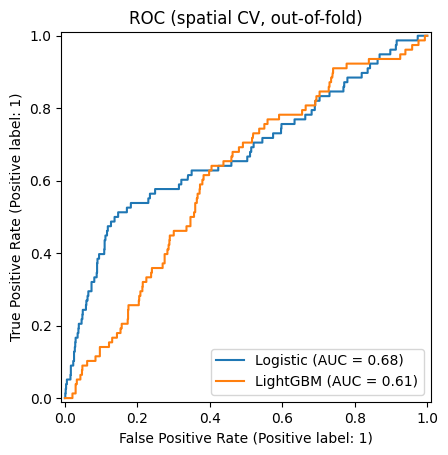

In [30]:
# plot the ROC curves
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_true_lr, p_lr, name="Logistic", ax=ax)
RocCurveDisplay.from_predictions(y_true_gbm, p_gbm, name="LightGBM", ax=ax)
ax.set_title("ROC (spatial CV, out-of-fold)")
plt.show()


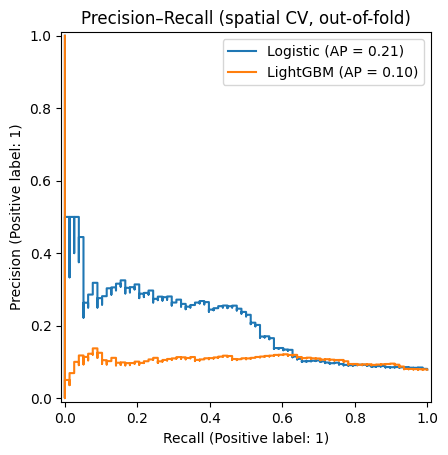

In [31]:
# precision-recall curves
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_true_lr, p_lr, name="Logistic", ax=ax)
PrecisionRecallDisplay.from_predictions(y_true_gbm, p_gbm, name="LightGBM", ax=ax)
ax.set_title("Precision–Recall (spatial CV, out-of-fold)")
ax.legend(loc='upper right')
plt.show()


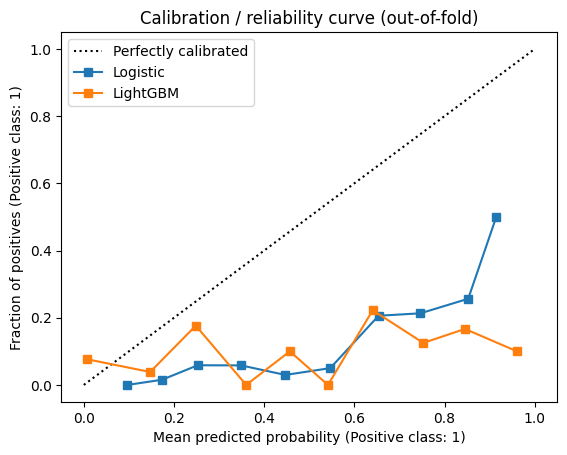

In [32]:
# calibration / reliability curves
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_true_lr, p_lr, n_bins=10, name="Logistic", ax=ax)
CalibrationDisplay.from_predictions(y_true_gbm, p_gbm, n_bins=10, name="LightGBM", ax=ax)
ax.set_title("Calibration / reliability curve (out-of-fold)")
ax.legend(loc='upper left')
plt.show()


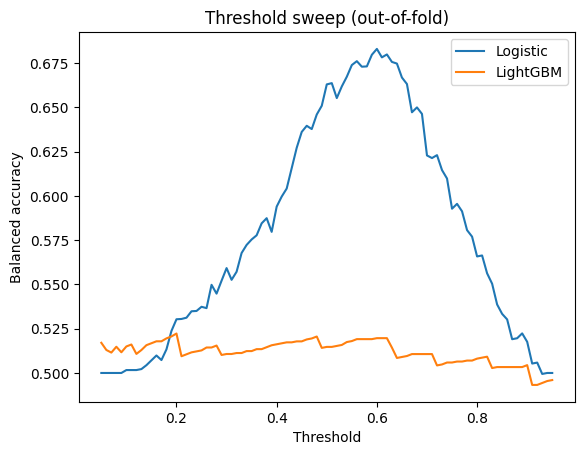

In [33]:
# threshold sweep for balanced accuracy
thresholds = np.linspace(0.05, 0.95, 91)

bal_lr = [balanced_accuracy_score(y_true_lr, (p_lr >= t).astype(int)) for t in thresholds]
bal_gbm = [balanced_accuracy_score(y_true_gbm, (p_gbm >= t).astype(int)) for t in thresholds]

fig, ax = plt.subplots()
ax.plot(thresholds, bal_lr, label="Logistic")
ax.plot(thresholds, bal_gbm, label="LightGBM")
ax.set_xlabel("Threshold")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Threshold sweep (out-of-fold)")
ax.legend()
plt.show()
